# Stage 3 task 1

### import modules and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import plotly.express as px
from matplotlib import pyplot as plt
# import seaborn
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.tools.eval_measures as smfem
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima_model import ARIMA

In [2]:
#define the utilities folder for team functions
sys.path.insert(0,"../util")
import teamsuperfileutilslib as tLibs

In [3]:
def weeklydata(statedata, normed=False, pop=1, pop_norm = 1):
    #first calculate the sum of each day, then get the daily increament
    #get a grad total of the days for the confirmed cases.
    weekdata = pd.DataFrame(statedata[statedata.columns[5:]].sum(axis=0)).reset_index()

    #rename column
    weekdata.columns=["date","increament"]
    
    #get the daily increament
    weekdata.increament = weekdata.increament.diff()

    #Fill any missing "na" values with 0
    weekdata.increament = weekdata.increament.fillna(value=0)
    if normed:
        weekdata["increament"] = weekdata.apply(lambda x: round((x["increament"] / pop) * pop_norm,0), axis=1)

    #convert date column to a pandas date
    weekdata["date"] = pd.to_datetime(weekdata["date"])
    
    weekdata["infect"] = -1
    startdate = -1
    for index, row in weekdata.iterrows():
        if row["increament"] > 0:
            startdate = index
            break
            
    weekdata["infect"] = weekdata.apply(lambda x: x.name - startdate if x.name >= startdate else -1, axis=1)
    #convet to int
    weekdata["increament"] = weekdata["increament"].apply(np.int64)
    
    return weekdata

In [4]:
def deathdata(statedata, bed_num):
    #first calculate the sum of each day, then get the daily increament
    #get a grad total of the days for the confirmed cases.
    d_data = pd.DataFrame(statedata[statedata.columns[5:]].sum(axis=0)).reset_index()
    
    #rename column
    d_data.columns=["date","deaths"]
    d_data.deaths = d_data.deaths.diff()
    d_data["bed_ratio"] = d_data.deaths/bed_num
    
    return d_data

In [5]:
#read indiana weekly data
superdata =  pd.read_csv("..\..\data\superCOVID-19datafame.csv")
indiana = superdata.loc[superdata['State'].isin(['IN'])]
#select other four states surrounding
ohio = superdata.loc[superdata['State'].isin(['OH'])]
michigan = superdata.loc[superdata['State'].isin(['MI'])]
kentucky = superdata.loc[superdata['State'].isin(['KY'])]
illinois = superdata.loc[superdata['State'].isin(['IL'])]

in_cc, in_d = tLibs.get_confirmed_deaths_tuple_df_with_population(indiana)

oh_cc, oh_d = tLibs.get_confirmed_deaths_tuple_df_with_population(ohio)
mi_cc, mi_d = tLibs.get_confirmed_deaths_tuple_df_with_population(michigan)
ky_cc, ky_d = tLibs.get_confirmed_deaths_tuple_df_with_population(kentucky)
il_cc, il_d = tLibs.get_confirmed_deaths_tuple_df_with_population(illinois)

in_infect_cc = weeklydata(in_cc)
in_infect_d = weeklydata(in_d)
#get the infected data from first day
in_infect_cc = in_infect_cc[in_infect_cc.apply(lambda x: (x["infect"] != -1), axis=1)]
in_infect_d = in_infect_d[in_infect_d.apply(lambda x: (x["infect"] != -1), axis=1)]

in_infect_cc.tail()

,date,increament,infect
291,2020-11-08,4652,247
292,2020-11-09,4132,248
293,2020-11-10,4864,249
294,2020-11-11,5042,250
295,2020-11-12,6605,251


In [6]:
in_infect_d.tail()

,date,increament,infect
291,2020-11-08,38,237
292,2020-11-09,35,238
293,2020-11-10,67,239
294,2020-11-11,31,240
295,2020-11-12,51,241


### Using regression model for confirmed cases

In [7]:
#linear regression:
linear_cc = smf.ols(formula='increament ~ 1 + infect', data=in_infect_cc).fit()

print(linear_cc.summary())
print(linear_cc.params)

                            OLS Regression Results                            
Dep. Variable:             increament   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     233.7
Date:                Sun, 15 Nov 2020   Prob (F-statistic):           1.07e-37
Time:                        23:31:33   Log-Likelihood:                -2013.4
No. Observations:                 252   AIC:                             4031.
Df Residuals:                     250   BIC:                             4038.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -262.8246     90.033     -2.919      0.0

In [8]:
#non-linear regression(polynomial):
nonlinear_cc = smf.ols(formula='increament ~ 1 + infect + I(infect ** 2.0)', data=in_infect_cc).fit()

print(nonlinear_cc.summary())
print(nonlinear_cc.params)

                            OLS Regression Results                            
Dep. Variable:             increament   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     242.8
Date:                Sun, 15 Nov 2020   Prob (F-statistic):           3.16e-59
Time:                        23:31:33   Log-Likelihood:                -1960.2
No. Observations:                 252   AIC:                             3926.
Df Residuals:                     249   BIC:                             3937.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          662.6900    109.040  

### Using regression model for deaths

In [9]:
#linear regression:
linear_d = smf.ols(formula='increament ~ 1 + infect', data=in_infect_d).fit()

print(linear_d.summary())
print(linear_d.params)

                            OLS Regression Results                            
Dep. Variable:             increament   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                  0.002065
Date:                Sun, 15 Nov 2020   Prob (F-statistic):              0.964
Time:                        23:31:33   Log-Likelihood:                -1056.5
No. Observations:                 242   AIC:                             2117.
Df Residuals:                     240   BIC:                             2124.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.9848      2.452      8.152      0.0

In [10]:
#non-linear regression(polynomial):
nonlinear_d = smf.ols(formula='increament ~ 1 + infect + I(infect ** 2.0)', data=in_infect_d).fit()

print(nonlinear_d.summary())
print(nonlinear_d.params)

                            OLS Regression Results                            
Dep. Variable:             increament   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     5.750
Date:                Sun, 15 Nov 2020   Prob (F-statistic):            0.00364
Time:                        23:31:33   Log-Likelihood:                -1050.9
No. Observations:                 242   AIC:                             2108.
Df Residuals:                     239   BIC:                             2118.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           28.9978      3.581  

### ploting regression models

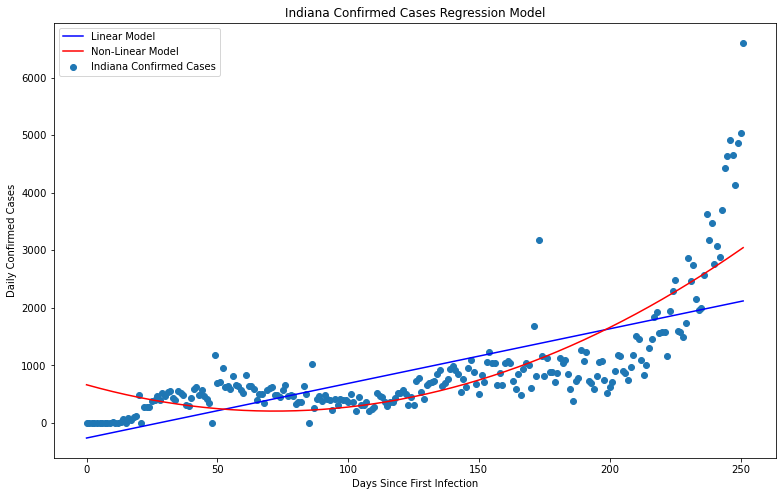

In [11]:
#plot confirmed cases models
plt.figure(figsize=(8*1.618, 8))
    
#Plot the real data
plt.scatter(in_infect_cc["infect"], in_infect_cc["increament"], label="Indiana Confirmed Cases")

#Plot the linear_model 
plt.plot(in_infect_cc["infect"], linear_cc.predict(in_infect_cc["infect"]), label="Linear Model", c="blue")
     
#Plot the nonlinear_model
plt.plot(in_infect_cc["infect"], nonlinear_cc.predict(in_infect_cc["infect"]), label="Non-Linear Model", c="red")

plt.xlabel("Days Since First Infection")
plt.ylabel("Daily Confirmed Cases")

plt.legend()

plt.title("Indiana Confirmed Cases Regression Model")
plt.show()

In [12]:
#Calculate RMSE 
linear_cc_rmse = smfem.rmse(x1=in_infect_cc["increament"], x2=linear_cc.predict(in_infect_cc["infect"]))
nonlinear_cc_rmse = smfem.rmse(x1=in_infect_cc["increament"], x2=nonlinear_cc.predict(in_infect_cc["infect"]))

print("Linear model RMSE: {}\nNon-Linear Model RMSE: {}".format(linear_cc_rmse, nonlinear_cc_rmse))

Linear model RMSE: 713.8926195048723
Non-Linear Model RMSE: 578.0997052101793


#### For confirmed cases, since non-linear model has a smaller RMSE value, it is better.

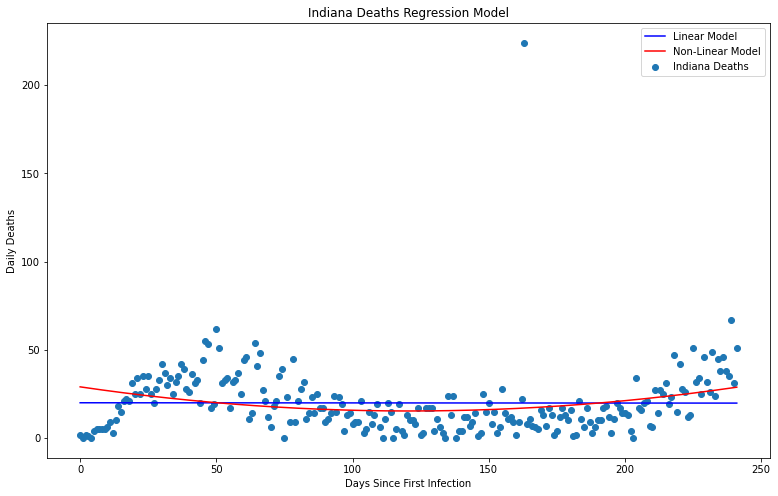

In [13]:
#plot deaths models
plt.figure(figsize=(8*1.618, 8))
    
#Plot the real data
plt.scatter(in_infect_d["infect"], in_infect_d["increament"], label="Indiana Deaths")

#Plot the linear_model 
plt.plot(in_infect_d["infect"], linear_d.predict(in_infect_d["infect"]), label="Linear Model", c="blue")
     
#Plot the nonlinear_model
plt.plot(in_infect_d["infect"], nonlinear_d.predict(in_infect_d["infect"]), label="Non-Linear Model", c="red")

plt.xlabel("Days Since First Infection")
plt.ylabel("Daily Deaths")

plt.legend()

plt.title("Indiana Deaths Regression Model")
plt.show()

In [14]:
#Calculate RMSE 
linear_d_rmse = smfem.rmse(x1=in_infect_d["increament"], x2=linear_d.predict(in_infect_d["infect"]))
nonlinear_d_rmse = smfem.rmse(x1=in_infect_d["increament"], x2=nonlinear_d.predict(in_infect_d["infect"]))

print("Linear model RMSE: {}\nNon-Linear Model RMSE: {}".format(linear_d_rmse, nonlinear_d_rmse))

Linear model RMSE: 19.048137395801803
Non-Linear Model RMSE: 18.605830615479437


#### For deaths, since non-linear model has a smaller RMSE value, it is a little bit better.

#### Find top five infected counties and model data

In [15]:
#use top five confirmed cases counties from stage 2
in_cc["cc_rate"] =  np.where(in_cc["population"] < 1, in_cc["population"], in_cc["10/18/20"]/in_cc["population"])
cc_high = in_cc.nlargest(5, ["cc_rate"])
cc_high.head(5)

,countyFIPS,County Name,State,stateFIPS,population,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,...,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,cc_rate
720,18017,Cass County,IN,18,37689,0,0,0,0,0,...,2466,2517,2531,2546,2568,2584,2604,2620,2649,0.058505
731,18039,Elkhart County,IN,18,206341,0,0,0,0,0,...,11062,11280,11542,11896,12228,12544,12725,12930,13341,0.040583
782,18141,St. Joseph County,IN,18,271826,0,0,0,0,0,...,11161,11339,11547,11818,12114,12365,12598,12823,13172,0.031910
730,18037,Dubois County,IN,18,42736,0,0,0,0,0,...,1723,1759,1802,1824,1849,1871,1905,1940,1974,0.031215
793,18163,Vanderburgh County,IN,18,181451,0,0,0,0,0,...,6919,6985,7162,7245,7387,7501,7552,7696,7792,0.030201


In [16]:
cc_high1 = weeklydata(cc_high.drop(columns=["cc_rate"]).iloc[[0]])
cc_high2 = weeklydata(cc_high.drop(columns=["cc_rate"]).iloc[[1]])
cc_high3 = weeklydata(cc_high.drop(columns=["cc_rate"]).iloc[[2]])
cc_high4 = weeklydata(cc_high.drop(columns=["cc_rate"]).iloc[[3]])
cc_high5 = weeklydata(cc_high.drop(columns=["cc_rate"]).iloc[[4]])

cc_high1 = cc_high1[cc_high1.apply(lambda x: (x["infect"] != -1), axis=1)]
cc_high2 = cc_high2[cc_high2.apply(lambda x: (x["infect"] != -1), axis=1)]
cc_high3 = cc_high3[cc_high3.apply(lambda x: (x["infect"] != -1), axis=1)]
cc_high4 = cc_high4[cc_high4.apply(lambda x: (x["infect"] != -1), axis=1)]
cc_high5 = cc_high5[cc_high5.apply(lambda x: (x["infect"] != -1), axis=1)]
#train the models
linear_cc1 = smf.ols(formula='increament ~ 1 + infect', data=cc_high1).fit()
nonlinear_cc1 = smf.ols(formula='increament ~ 1 + infect + I(infect ** 2.0)', data=cc_high1).fit()
linear_cc2 = smf.ols(formula='increament ~ 1 + infect', data=cc_high2).fit()
nonlinear_cc2 = smf.ols(formula='increament ~ 1 + infect + I(infect ** 2.0)', data=cc_high2).fit()
linear_cc3 = smf.ols(formula='increament ~ 1 + infect', data=cc_high3).fit()
nonlinear_cc3 = smf.ols(formula='increament ~ 1 + infect + I(infect ** 2.0)', data=cc_high3).fit()
linear_cc4 = smf.ols(formula='increament ~ 1 + infect', data=cc_high4).fit()
nonlinear_cc4 = smf.ols(formula='increament ~ 1 + infect + I(infect ** 2.0)', data=cc_high4).fit()
linear_cc5 = smf.ols(formula='increament ~ 1 + infect', data=cc_high5).fit()
nonlinear_cc5 = smf.ols(formula='increament ~ 1 + infect + I(infect ** 2.0)', data=cc_high5).fit()

dt1 = DecisionTreeRegressor(max_depth=4)
dt1.fit(cc_high1["infect"].values.reshape(-1,1), cc_high1["increament"].values.reshape(-1,1))
dt2 = DecisionTreeRegressor(max_depth=4)
dt2.fit(cc_high2["infect"].values.reshape(-1,1), cc_high2["increament"].values.reshape(-1,1))
dt3 = DecisionTreeRegressor(max_depth=4)
dt3.fit(cc_high3["infect"].values.reshape(-1,1), cc_high3["increament"].values.reshape(-1,1))
dt4 = DecisionTreeRegressor(max_depth=4)
dt4.fit(cc_high4["infect"].values.reshape(-1,1), cc_high4["increament"].values.reshape(-1,1))
dt5 = DecisionTreeRegressor(max_depth=4)
dt5.fit(cc_high5["infect"].values.reshape(-1,1), cc_high5["increament"].values.reshape(-1,1))

rf1 = RandomForestRegressor(max_depth=4, random_state=0)
rf1.fit(cc_high1["infect"].values.reshape(-1,1), cc_high1["increament"].values.reshape(-1,1))
rf2 = RandomForestRegressor(max_depth=4, random_state=0)
rf2.fit(cc_high2["infect"].values.reshape(-1,1), cc_high2["increament"].values.reshape(-1,1))
rf3 = RandomForestRegressor(max_depth=4, random_state=0)
rf3.fit(cc_high3["infect"].values.reshape(-1,1), cc_high3["increament"].values.reshape(-1,1))
rf4 = RandomForestRegressor(max_depth=4, random_state=0)
rf4.fit(cc_high4["infect"].values.reshape(-1,1), cc_high4["increament"].values.reshape(-1,1))
rf5 = RandomForestRegressor(max_depth=4, random_state=0)
rf5.fit(cc_high5["infect"].values.reshape(-1,1), cc_high5["increament"].values.reshape(-1,1))

ar1 = ARIMA(cc_high1["increament"], order=(5,1,0))
ar1_fit = ar1.fit(disp=0)

ar2 = ARIMA(cc_high2["increament"], order=(5,1,0))
ar2_fit = ar2.fit(disp=0)

ar3 = ARIMA(cc_high3["increament"], order=(5,1,0))
ar3_fit = ar3.fit(disp=0)

ar4 = ARIMA(cc_high4["increament"], order=(5,1,0))
ar4_fit = ar4.fit(disp=0)

ar5 = ARIMA(cc_high5["increament"], order=(5,1,0))
ar5_fit = ar5.fit(disp=0)

c:\users\samzhang\miniconda3\lib\site-packages\ipykernel_launcher.py:36: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

c:\users\samzhang\miniconda3\lib\site-packages\ipykernel_launcher.py:38: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

c:\users\samzhang\miniconda3\lib\site-packages\ipykernel_launcher.py:40: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

c:\users\samzhang\miniconda3\lib\site-packages\ipykernel_launcher.py:42: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

c:\users\samzhang\miniconda3\lib\site-packages\ipykernel_launcher.py:44: DataCon

c:\users\samzhang\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



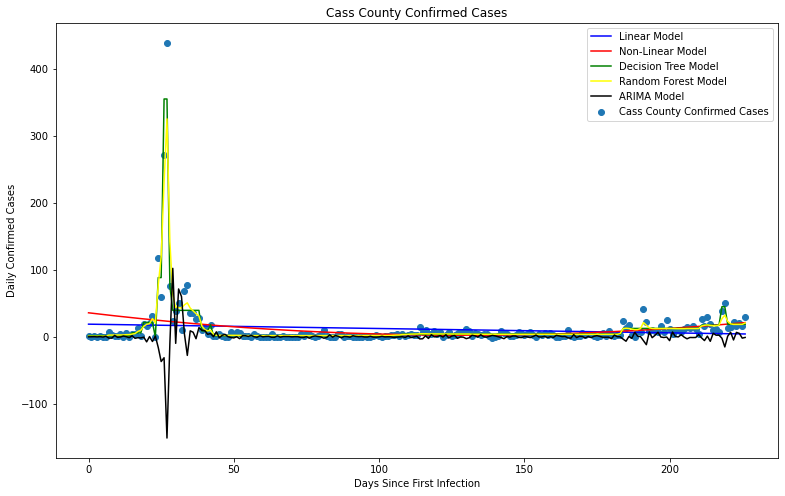

In [17]:
#plot first county
plt.figure(figsize=(8*1.618, 8))
    
#Plot the real data
plt.scatter(cc_high1["infect"], cc_high1["increament"], label="Cass County Confirmed Cases")

#Plot the linear_model 
plt.plot(cc_high1["infect"], linear_cc1.predict(cc_high1["infect"]), label="Linear Model", c="blue")
     
#Plot the nonlinear_model
plt.plot(cc_high1["infect"], nonlinear_cc1.predict(cc_high1["infect"]), label="Non-Linear Model", c="red")

#Plot the decision tree model 
plt.plot(cc_high1["infect"], dt1.predict(cc_high1["infect"].values.reshape(-1,1)), label="Decision Tree Model", c="green")

#Plot the random forest model 
plt.plot(cc_high1["infect"], rf1.predict(cc_high1["infect"].values.reshape(-1,1)), label="Random Forest Model", c="yellow")

#Plot the ARIMA model 
plt.plot(cc_high1["infect"], ar1_fit.predict(1,len(cc_high1["infect"])), label="ARIMA Model", c="black")

plt.xlabel("Days Since First Infection")
plt.ylabel("Daily Confirmed Cases")

plt.legend()

plt.title("Cass County Confirmed Cases")
plt.show()

c:\users\samzhang\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



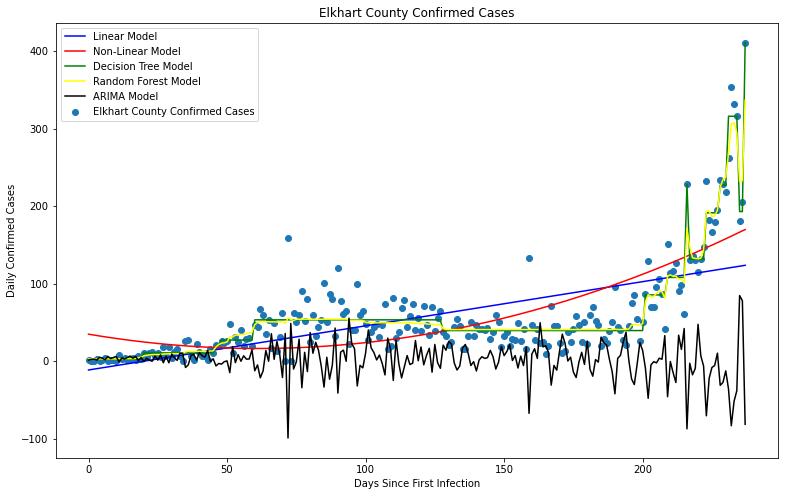

In [18]:
#plot second county
plt.figure(figsize=(8*1.618, 8))
    
#Plot the real data
plt.scatter(cc_high2["infect"], cc_high2["increament"], label="Elkhart County Confirmed Cases")

#Plot the linear_model 
plt.plot(cc_high2["infect"], linear_cc2.predict(cc_high2["infect"]), label="Linear Model", c="blue")
     
#Plot the nonlinear_model
plt.plot(cc_high2["infect"], nonlinear_cc2.predict(cc_high2["infect"]), label="Non-Linear Model", c="red")

#Plot the decision tree model 
plt.plot(cc_high2["infect"], dt2.predict(cc_high2["infect"].values.reshape(-1,1)), label="Decision Tree Model", c="green")

#Plot the random forest model 
plt.plot(cc_high2["infect"], rf2.predict(cc_high2["infect"].values.reshape(-1,1)), label="Random Forest Model", c="yellow")

#Plot the ARIMA model 
plt.plot(cc_high2["infect"], ar2_fit.predict(1,len(cc_high2["infect"])), label="ARIMA Model", c="black")

plt.xlabel("Days Since First Infection")
plt.ylabel("Daily Confirmed Cases")

plt.legend()

plt.title("Elkhart County Confirmed Cases")
plt.show()

c:\users\samzhang\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



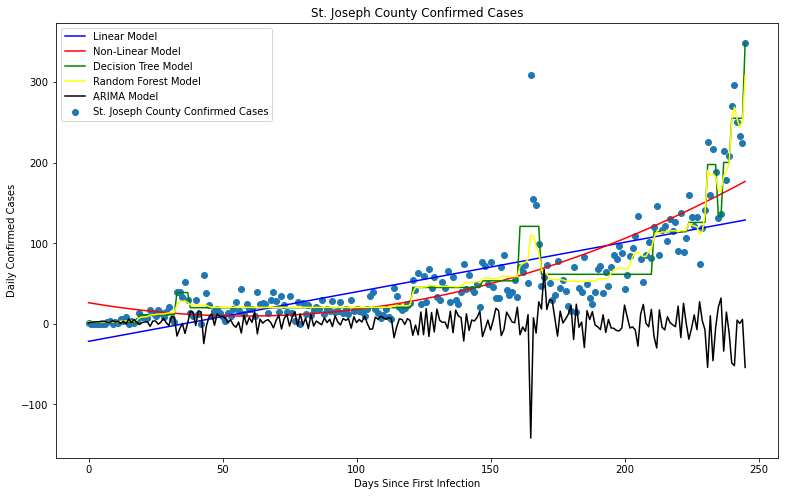

In [19]:
#plot third county
plt.figure(figsize=(8*1.618, 8))
    
#Plot the real data
plt.scatter(cc_high3["infect"], cc_high3["increament"], label="St. Joseph County Confirmed Cases")

#Plot the linear_model 
plt.plot(cc_high3["infect"], linear_cc3.predict(cc_high3["infect"]), label="Linear Model", c="blue")
     
#Plot the nonlinear_model
plt.plot(cc_high3["infect"], nonlinear_cc3.predict(cc_high3["infect"]), label="Non-Linear Model", c="red")

#Plot the decision tree model 
plt.plot(cc_high3["infect"], dt3.predict(cc_high3["infect"].values.reshape(-1,1)), label="Decision Tree Model", c="green")

#Plot the random forest model 
plt.plot(cc_high3["infect"], rf3.predict(cc_high3["infect"].values.reshape(-1,1)), label="Random Forest Model", c="yellow")

#Plot the ARIMA model 
plt.plot(cc_high3["infect"], ar3_fit.predict(1,len(cc_high3["infect"])), label="ARIMA Model", c="black")

plt.xlabel("Days Since First Infection")
plt.ylabel("Daily Confirmed Cases")

plt.legend()

plt.title("St. Joseph County Confirmed Cases")
plt.show()

c:\users\samzhang\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



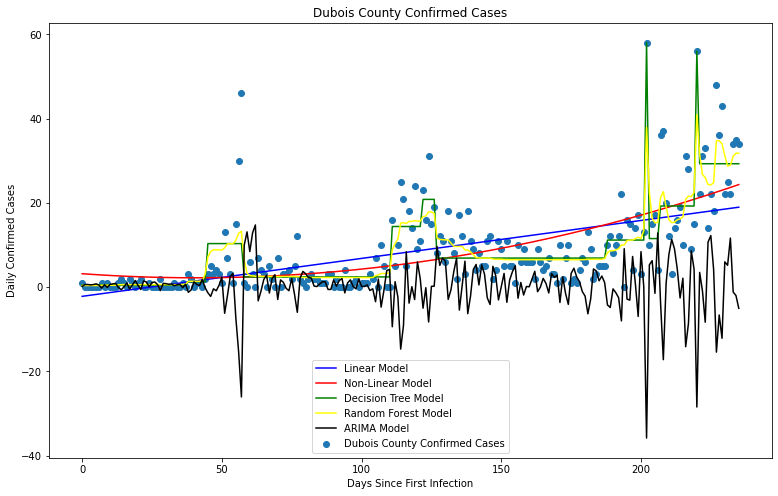

In [20]:
#plot forth county
plt.figure(figsize=(8*1.618, 8))
    
#Plot the real data
plt.scatter(cc_high4["infect"], cc_high4["increament"], label="Dubois County Confirmed Cases")

#Plot the linear_model 
plt.plot(cc_high4["infect"], linear_cc4.predict(cc_high4["infect"]), label="Linear Model", c="blue")
     
#Plot the nonlinear_model
plt.plot(cc_high4["infect"], nonlinear_cc4.predict(cc_high4["infect"]), label="Non-Linear Model", c="red")

#Plot the decision tree model 
plt.plot(cc_high4["infect"], dt4.predict(cc_high4["infect"].values.reshape(-1,1)), label="Decision Tree Model", c="green")

#Plot the random forest model 
plt.plot(cc_high4["infect"], rf4.predict(cc_high4["infect"].values.reshape(-1,1)), label="Random Forest Model", c="yellow")

#Plot the ARIMA model 
plt.plot(cc_high4["infect"], ar4_fit.predict(1,len(cc_high4["infect"])), label="ARIMA Model", c="black")

plt.xlabel("Days Since First Infection")
plt.ylabel("Daily Confirmed Cases")

plt.legend()

plt.title("Dubois County Confirmed Cases")
plt.show()

c:\users\samzhang\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



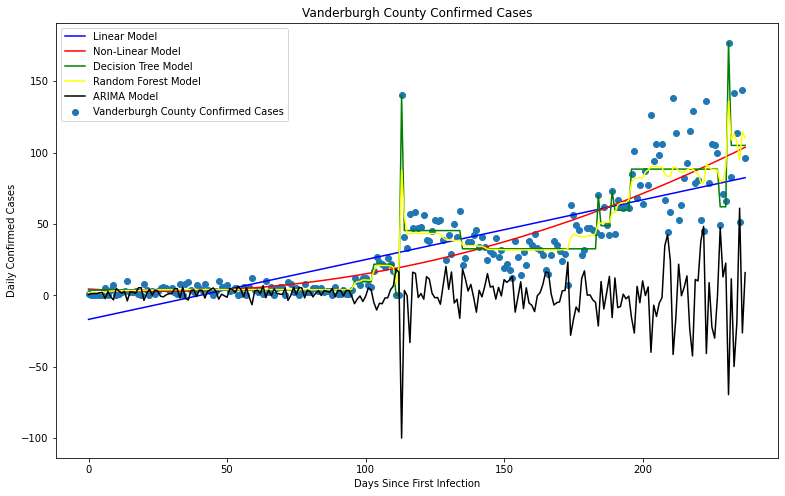

In [21]:
#plot fifth county
plt.figure(figsize=(8*1.618, 8))
    
#Plot the real data
plt.scatter(cc_high5["infect"], cc_high5["increament"], label="Vanderburgh County Confirmed Cases")

#Plot the linear_model 
plt.plot(cc_high5["infect"], linear_cc5.predict(cc_high5["infect"]), label="Linear Model", c="blue")
     
#Plot the nonlinear_model
plt.plot(cc_high5["infect"], nonlinear_cc5.predict(cc_high5["infect"]), label="Non-Linear Model", c="red")

#Plot the decision tree model 
plt.plot(cc_high5["infect"], dt5.predict(cc_high5["infect"].values.reshape(-1,1)), label="Decision Tree Model", c="green")

#Plot the random forest model 
plt.plot(cc_high5["infect"], rf5.predict(cc_high5["infect"].values.reshape(-1,1)), label="Random Forest Model", c="yellow")

#Plot the ARIMA model 
plt.plot(cc_high5["infect"], ar5_fit.predict(1,len(cc_high5["infect"])), label="ARIMA Model", c="black")

plt.xlabel("Days Since First Infection")
plt.ylabel("Daily Confirmed Cases")

plt.legend()

plt.title("Vanderburgh County Confirmed Cases")
plt.show()

In [22]:
#Calculate RMSE for county 1
linear_cc1_rmse = smfem.rmse(x1=cc_high1["increament"], x2=linear_cc1.predict(cc_high1["infect"]))
nonlinear_cc1_rmse = smfem.rmse(x1=cc_high1["increament"], x2=nonlinear_cc1.predict(cc_high1["infect"]))
dt_cc1_rmse = smfem.rmse(x1=cc_high1["increament"], x2=dt1.predict(cc_high1["infect"].values.reshape(-1,1)))
rf_cc1_rmse = smfem.rmse(x1=cc_high1["increament"], x2=rf1.predict(cc_high1["infect"].values.reshape(-1,1)))
ar_cc1_rmse = smfem.rmse(x1=cc_high1["increament"], x2=ar1_fit.predict(1,len(cc_high1["infect"])))
print("Linear model RMSE: {}\nNon-Linear Model RMSE: {}\nDecision Tree Model RMSE: {}\nRandom Forest Model RMSE: {}\nARIMA Model RMSE: {}".format(linear_cc1_rmse, nonlinear_cc1_rmse, dt_cc1_rmse, rf_cc1_rmse,ar_cc1_rmse))

Linear model RMSE: 36.03529800218457
Non-Linear Model RMSE: 35.204170216243995
Decision Tree Model RMSE: 10.185580217285676
Random Forest Model RMSE: 11.906349226662785
ARIMA Model RMSE: 48.26312673470737


c:\users\samzhang\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [23]:
#Calculate RMSE for county 2
linear_cc2_rmse = smfem.rmse(x1=cc_high2["increament"], x2=linear_cc2.predict(cc_high2["infect"]))
nonlinear_cc2_rmse = smfem.rmse(x1=cc_high2["increament"], x2=nonlinear_cc2.predict(cc_high2["infect"]))
dt_cc2_rmse = smfem.rmse(x1=cc_high2["increament"], x2=dt2.predict(cc_high2["infect"].values.reshape(-1,1)))
rf_cc2_rmse = smfem.rmse(x1=cc_high2["increament"], x2=rf2.predict(cc_high2["infect"].values.reshape(-1,1)))
ar_cc2_rmse = smfem.rmse(x1=cc_high2["increament"], x2=ar2_fit.predict(1,len(cc_high2["infect"])))
print("Linear model RMSE: {}\nNon-Linear Model RMSE: {}\nDecision Tree Model RMSE: {}\nRandom Forest Model RMSE: {}\nARIMA Model RMSE: {}".format(linear_cc2_rmse, nonlinear_cc2_rmse, dt_cc2_rmse, rf_cc2_rmse,ar_cc2_rmse))

Linear model RMSE: 49.3853051656562
Non-Linear Model RMSE: 44.7313940528716
Decision Tree Model RMSE: 20.265501443692177
Random Forest Model RMSE: 20.919688181019147
ARIMA Model RMSE: 95.5806494991576


c:\users\samzhang\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [24]:
#Calculate RMSE for county 3
linear_cc3_rmse = smfem.rmse(x1=cc_high3["increament"], x2=linear_cc3.predict(cc_high3["infect"]))
nonlinear_cc3_rmse = smfem.rmse(x1=cc_high3["increament"], x2=nonlinear_cc3.predict(cc_high3["infect"]))
dt_cc3_rmse = smfem.rmse(x1=cc_high3["increament"], x2=dt3.predict(cc_high3["infect"].values.reshape(-1,1)))
rf_cc3_rmse = smfem.rmse(x1=cc_high3["increament"], x2=rf3.predict(cc_high3["infect"].values.reshape(-1,1)))
ar_cc3_rmse = smfem.rmse(x1=cc_high3["increament"], x2=ar3_fit.predict(1,len(cc_high3["infect"])))
print("Linear model RMSE: {}\nNon-Linear Model RMSE: {}\nDecision Tree Model RMSE: {}\nRandom Forest Model RMSE: {}\nARIMA Model RMSE: {}".format(linear_cc3_rmse, nonlinear_cc3_rmse, dt_cc3_rmse, rf_cc3_rmse,ar_cc3_rmse))

Linear model RMSE: 40.05313859297842
Non-Linear Model RMSE: 33.65869923649713
Decision Tree Model RMSE: 21.774646050083636
Random Forest Model RMSE: 20.20259597206399
ARIMA Model RMSE: 87.12583775447617


c:\users\samzhang\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [25]:
#Calculate RMSE for county 4
linear_cc4_rmse = smfem.rmse(x1=cc_high4["increament"], x2=linear_cc4.predict(cc_high4["infect"]))
nonlinear_cc4_rmse = smfem.rmse(x1=cc_high4["increament"], x2=nonlinear_cc4.predict(cc_high4["infect"]))
dt_cc4_rmse = smfem.rmse(x1=cc_high4["increament"], x2=dt4.predict(cc_high4["infect"].values.reshape(-1,1)))
rf_cc4_rmse = smfem.rmse(x1=cc_high4["increament"], x2=rf4.predict(cc_high4["infect"].values.reshape(-1,1)))
ar_cc4_rmse = smfem.rmse(x1=cc_high4["increament"], x2=ar4_fit.predict(1,len(cc_high4["infect"])))
print("Linear model RMSE: {}\nNon-Linear Model RMSE: {}\nDecision Tree Model RMSE: {}\nRandom Forest Model RMSE: {}\nARIMA Model RMSE: {}".format(linear_cc4_rmse, nonlinear_cc4_rmse, dt_cc4_rmse, rf_cc4_rmse,ar_cc4_rmse))

Linear model RMSE: 8.61060942407229
Non-Linear Model RMSE: 8.260076508700692
Decision Tree Model RMSE: 5.618749754346347
Random Forest Model RMSE: 5.355563580546223
ARIMA Model RMSE: 17.15273994762374


c:\users\samzhang\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [26]:
#Calculate RMSE for county 5
linear_cc5_rmse = smfem.rmse(x1=cc_high5["increament"], x2=linear_cc5.predict(cc_high5["infect"]))
nonlinear_cc5_rmse = smfem.rmse(x1=cc_high5["increament"], x2=nonlinear_cc5.predict(cc_high5["infect"]))
dt_cc5_rmse = smfem.rmse(x1=cc_high5["increament"], x2=dt5.predict(cc_high5["infect"].values.reshape(-1,1)))
rf_cc5_rmse = smfem.rmse(x1=cc_high5["increament"], x2=rf5.predict(cc_high5["infect"].values.reshape(-1,1)))
ar_cc5_rmse = smfem.rmse(x1=cc_high5["increament"], x2=ar5_fit.predict(1,len(cc_high5["infect"])))
print("Linear model RMSE: {}\nNon-Linear Model RMSE: {}\nDecision Tree Model RMSE: {}\nRandom Forest Model RMSE: {}\nARIMA Model RMSE: {}".format(linear_cc5_rmse, nonlinear_cc5_rmse, dt_cc5_rmse, rf_cc5_rmse,ar_cc5_rmse))

Linear model RMSE: 21.045507464270337
Non-Linear Model RMSE: 18.70928864013146
Decision Tree Model RMSE: 12.501183988973395
Random Forest Model RMSE: 12.423685127582234
ARIMA Model RMSE: 55.28040860856543


c:\users\samzhang\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



### Utilize the hospital data to calculate the point of no return for a state.

In [27]:
#read hospital data
hospital = pd.read_csv("..\..\data\Definitive_Health_USA_Hospital_Beds.csv")
#get indiana and other four states hospital data
hospital = hospital.dropna()
in_hos = hospital[hospital['HQ_STATE']=="IN"]
oh_hos = hospital[hospital['HQ_STATE']=="OH"]
mi_hos = hospital[hospital['HQ_STATE']=="MI"]
ky_hos = hospital[hospital['HQ_STATE']=="KY"]
il_hos = hospital[hospital['HQ_STATE']=="IL"]
in_hos.head()

,X,Y,OBJECTID,HOSPITAL_NAME,HOSPITAL_TYPE,HQ_ADDRESS,HQ_ADDRESS1,HQ_CITY,HQ_STATE,HQ_ZIP_CODE,...,CNTY_FIPS,FIPS,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,ADULT_ICU_BEDS,PEDI_ICU_BEDS,BED_UTILIZATION,Potential_Increase_In_Bed_Capac,AVG_VENTILATOR_USAGE
4431,-85.414628,40.196898,4432,AMG Specialty Hospital - Central Indiana Munci...,Long Term Acute Care Hospital,2401 W University Ave,5th Floor E Tower,Muncie,IN,47303,...,35.0,18035.0,41.0,41.0,8,8,0.0,0.516605,0,4
4586,-87.447544,41.634837,4587,Regency Hospital of Northwest Indiana,Long Term Acute Care Hospital,4321 Fir St,4th Floor,East Chicago,IN,46312,...,89.0,18089.0,61.0,61.0,6,6,0.0,0.656995,0,3
4858,-85.265658,41.441860,4859,Northeastern Center,Psychiatric Hospital,220 S Main St,Suite 817,Kendallville,IN,46755,...,113.0,18113.0,16.0,16.0,0,0,0.0,0.665925,0,0


In [28]:
#get number of icu beds for each state
in_bed = in_hos.NUM_ICU_BEDS.sum()
oh_bed = oh_hos.NUM_ICU_BEDS.sum()
mi_bed = mi_hos.NUM_ICU_BEDS.sum()
ky_bed = ky_hos.NUM_ICU_BEDS.sum()
il_bed = il_hos.NUM_ICU_BEDS.sum()

in_bed_d = deathdata(in_d, in_bed)
oh_bed_d = deathdata(oh_d, oh_bed)
mi_bed_d = deathdata(mi_d, mi_bed)
ky_bed_d = deathdata(ky_d, ky_bed)
il_bed_d = deathdata(il_d, il_bed)
in_bed_d.tail()

,date,deaths,bed_ratio
291,11/8/20,38.0,2.714286
292,11/9/20,35.0,2.500000
293,11/10/20,67.0,4.785714
294,11/11/20,31.0,2.214286
295,11/12/20,51.0,3.642857


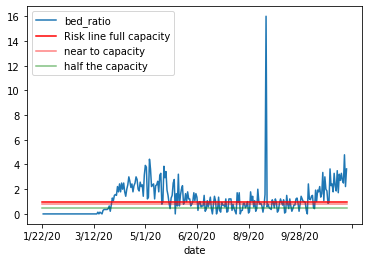

In [29]:
in_bed_d.plot(x='date',y='bed_ratio')
sns.lineplot(x=in_bed_d.index,y=[1]*len(in_bed_d),color='r',label='Risk line full capacity')
sns.lineplot(x=in_bed_d.index,y=[.8]*len(in_bed_d),color='r',alpha=.5,label ='near to capacity' )
sns.lineplot(x=in_bed_d.index,y=[.5]*len(in_bed_d),color='g',alpha=.5,label ='half the capacity' )

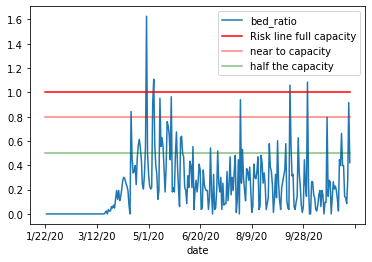

In [30]:
oh_bed_d.plot(x='date',y='bed_ratio')
sns.lineplot(x=oh_bed_d.index,y=[1]*len(oh_bed_d),color='r',label='Risk line full capacity')
sns.lineplot(x=oh_bed_d.index,y=[.8]*len(oh_bed_d),color='r',alpha=.5,label ='near to capacity' )
sns.lineplot(x=oh_bed_d.index,y=[.5]*len(oh_bed_d),color='g',alpha=.5,label ='half the capacity' )

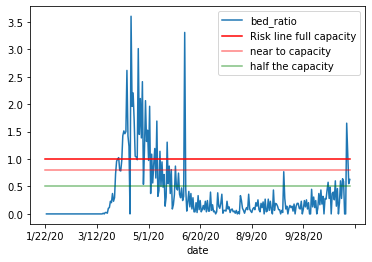

In [31]:
mi_bed_d.plot(x='date',y='bed_ratio')
sns.lineplot(x=mi_bed_d.index,y=[1]*len(mi_bed_d),color='r',label='Risk line full capacity')
sns.lineplot(x=mi_bed_d.index,y=[.8]*len(mi_bed_d),color='r',alpha=.5,label ='near to capacity' )
sns.lineplot(x=mi_bed_d.index,y=[.5]*len(mi_bed_d),color='g',alpha=.5,label ='half the capacity' )

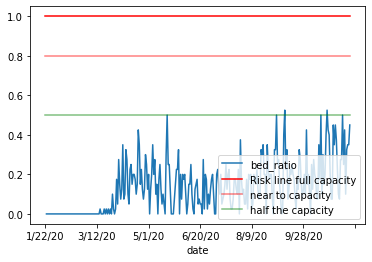

In [32]:
ky_bed_d.plot(x='date',y='bed_ratio')
sns.lineplot(x=ky_bed_d.index,y=[1]*len(ky_bed_d),color='r',label='Risk line full capacity')
sns.lineplot(x=ky_bed_d.index,y=[.8]*len(ky_bed_d),color='r',alpha=.5,label ='near to capacity' )
sns.lineplot(x=ky_bed_d.index,y=[.5]*len(ky_bed_d),color='g',alpha=.5,label ='half the capacity' )

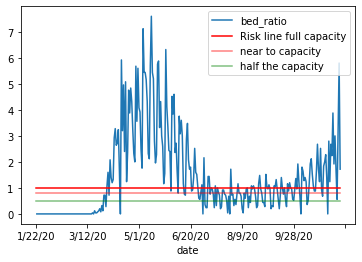

In [33]:
il_bed_d.plot(x='date',y='bed_ratio')
sns.lineplot(x=il_bed_d.index,y=[1]*len(il_bed_d),color='r',label='Risk line full capacity')
sns.lineplot(x=il_bed_d.index,y=[.8]*len(il_bed_d),color='r',alpha=.5,label ='near to capacity' )
sns.lineplot(x=il_bed_d.index,y=[.5]*len(il_bed_d),color='g',alpha=.5,label ='half the capacity' )

### Use 5 different variables from the enrichment data to predict the spread rate (cases and deaths) of COVID-19 in a county.

In [34]:
#get enrichment data from stage 2
in_enrich = pd.read_csv("enrich_in.csv")
in_enrich.head()

,Unnamed: 0,countyFIPS_x,County Name,State,stateFIPS,population,total_confirmed,total_deaths,sex_ratio,85_years_over,median_age,norm_cc,norm_d
0,219,18003,Allen County,IN,18,379299,5949,210,95.2,1983,37.4,15.684196,0.553653
1,220,18005,Bartholomew County,IN,18,83779,1160,61,92.8,4542,38.0,13.845952,0.728106
2,221,18011,Boone County,IN,18,67843,964,49,98.5,1003,38.8,14.209277,0.722256
3,222,18019,Clark County,IN,18,118302,2117,63,103.8,1927,45.3,17.894879,0.532535
4,223,18035,Delaware County,IN,18,114135,1847,62,93.0,1698,38.3,16.182591,0.543216


In [35]:
#create regression model based on population
dt_pop = DecisionTreeRegressor(max_depth=5)
dt_pop.fit(in_enrich["population"].values.reshape(-1,1), in_enrich["total_confirmed"].values.reshape(-1,1))

rf_pop = RandomForestRegressor(max_depth=5, random_state=0)
rf_pop.fit(in_enrich["population"].values.reshape(-1,1), in_enrich["total_confirmed"].values.reshape(-1,1))

#create regression model based on sex_ratio
dt_sex = DecisionTreeRegressor(max_depth=5)
dt_sex.fit(in_enrich["sex_ratio"].values.reshape(-1,1), in_enrich["total_confirmed"].values.reshape(-1,1))

rf_sex = RandomForestRegressor(max_depth=5, random_state=0)
rf_sex.fit(in_enrich["sex_ratio"].values.reshape(-1,1), in_enrich["total_confirmed"].values.reshape(-1,1))

#create regression model based on 85_year_older population
dt_85 = DecisionTreeRegressor(max_depth=5)
dt_85.fit(in_enrich["85_years_over"].values.reshape(-1,1), in_enrich["total_confirmed"].values.reshape(-1,1))

rf_85 = RandomForestRegressor(max_depth=5, random_state=0)
rf_85.fit(in_enrich["85_years_over"].values.reshape(-1,1), in_enrich["total_confirmed"].values.reshape(-1,1))

#create regression model based on median age
dt_age = DecisionTreeRegressor(max_depth=5)
dt_age.fit(in_enrich["median_age"].values.reshape(-1,1), in_enrich["total_confirmed"].values.reshape(-1,1))

rf_age = RandomForestRegressor(max_depth=5, random_state=0)
rf_age.fit(in_enrich["median_age"].values.reshape(-1,1), in_enrich["total_confirmed"].values.reshape(-1,1))

c:\users\samzhang\miniconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

c:\users\samzhang\miniconda3\lib\site-packages\ipykernel_launcher.py:13: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

c:\users\samzhang\miniconda3\lib\site-packages\ipykernel_launcher.py:20: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

c:\users\samzhang\miniconda3\lib\site-packages\ipykernel_launcher.py:27: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestRegressor(max_depth=5, random_state=0)

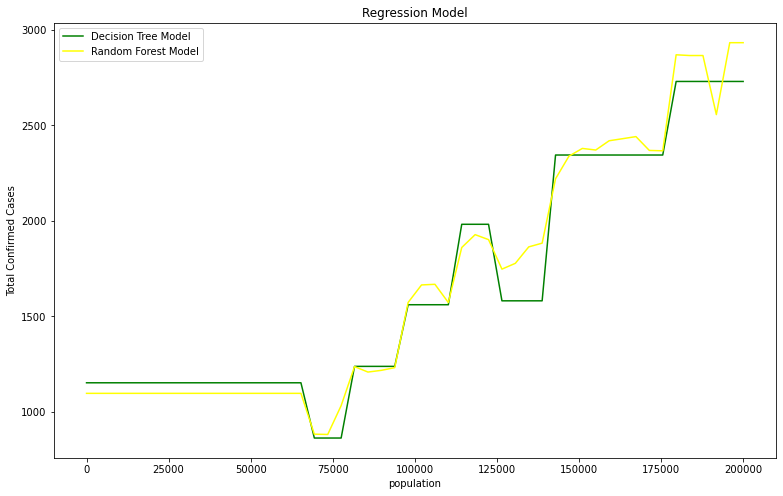

In [36]:
plt.figure(figsize=(8*1.618, 8))
#Plot the decision tree model 
plt.plot(np.linspace(0,200000).reshape(-1, 1), dt_pop.predict(np.linspace(0,200000).reshape(-1, 1)), label="Decision Tree Model", c="green")

#Plot the random forest model 
plt.plot(np.linspace(0,200000).reshape(-1, 1), rf_pop.predict(np.linspace(0,200000).reshape(-1, 1)), label="Random Forest Model", c="yellow")

plt.xlabel("population")
plt.ylabel("Total Confirmed Cases")

plt.legend()

plt.title("Regression Model")
plt.show()

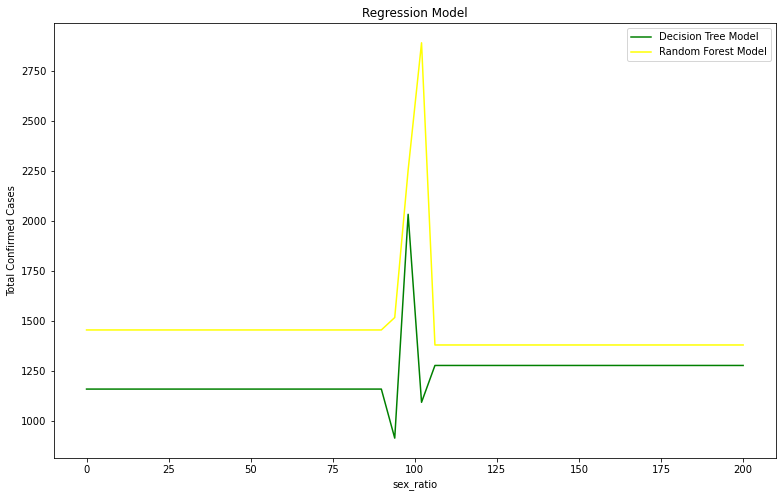

In [37]:
plt.figure(figsize=(8*1.618, 8))
#Plot the decision tree model 
plt.plot(np.linspace(0,200).reshape(-1, 1), dt_sex.predict(np.linspace(0,200).reshape(-1, 1)), label="Decision Tree Model", c="green")

#Plot the random forest model 
plt.plot(np.linspace(0,200).reshape(-1, 1), rf_sex.predict(np.linspace(0,200).reshape(-1, 1)), label="Random Forest Model", c="yellow")

plt.xlabel("sex_ratio")
plt.ylabel("Total Confirmed Cases")

plt.legend()

plt.title("Regression Model")
plt.show()

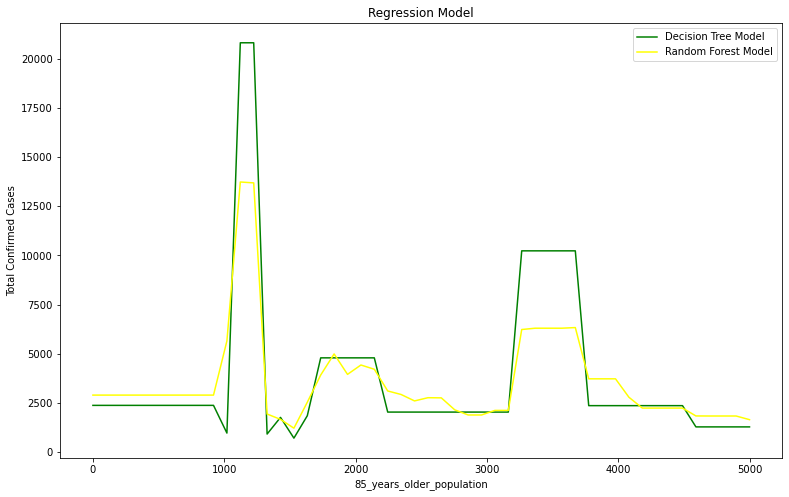

In [38]:
plt.figure(figsize=(8*1.618, 8))
#Plot the decision tree model 
plt.plot(np.linspace(0,5000).reshape(-1, 1), dt_85.predict(np.linspace(0,5000).reshape(-1, 1)), label="Decision Tree Model", c="green")

#Plot the random forest model 
plt.plot(np.linspace(0,5000).reshape(-1, 1), rf_85.predict(np.linspace(0,5000).reshape(-1, 1)), label="Random Forest Model", c="yellow")

plt.xlabel("85_years_older_population")
plt.ylabel("Total Confirmed Cases")

plt.legend()

plt.title("Regression Model")
plt.show()

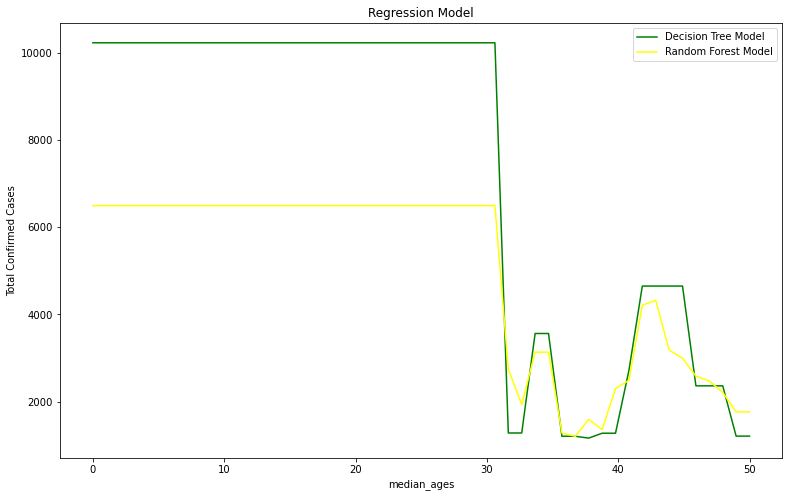

In [39]:
plt.figure(figsize=(8*1.618, 8))
#Plot the decision tree model 
plt.plot(np.linspace(0,50).reshape(-1, 1), dt_age.predict(np.linspace(0,50).reshape(-1, 1)), label="Decision Tree Model", c="green")

#Plot the random forest model 
plt.plot(np.linspace(0,50).reshape(-1, 1), rf_age.predict(np.linspace(0,50).reshape(-1, 1)), label="Random Forest Model", c="yellow")

plt.xlabel("median_ages")
plt.ylabel("Total Confirmed Cases")

plt.legend()

plt.title("Regression Model")
plt.show()